# __Part A: Convolutional Neural Network__

<a class="anchor" id="1"></a>
## <font color='#71a1e3'> __Previously__</font>
<hr style="height:1.5px;border-width:0;background-color: #4c8c77">

1. Exploratory data analysis was done
2. 128 x 128 includes data augmentation - cutmix will be used for the rest 
3. Best model currently is 99.2 cnn2 cutmix

<a class="anchor" id="3"></a>
## <font color='#71a1e3'>__Import Libraries__</font>
<hr style="height:1.5px;border-width:0;background-color: #4c8c77">

Here is to import all the necessary libraries

In [1]:
# !unzip 1.zip

In [2]:
%pip install tensorflow_addons keras-tuner pandas matplotlib seaborn scikit-learn tqdm efficientnet

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


### Other Imports

In [3]:
import numpy as np
import pandas as pd

import seaborn as sns

from matplotlib import pyplot as plt

from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, confusion_matrix, cohen_kappa_score, matthews_corrcoef
from sklearn.metrics import classification_report,accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer
from sklearn.metrics import classification_report, accuracy_score

import os, time, math, datetime, warnings, pytz, glob
from IPython.display import display
from functools import reduce
import absl.logging
from tqdm import tqdm
import logging
from efficientnet.tfkeras import EfficientNetB3

absl.logging.set_verbosity(absl.logging.ERROR)
logging.getLogger('tensorflow').disabled = True
warnings.filterwarnings('ignore')

### Tensorflow Import

In [4]:
import tensorflow as tf
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow import expand_dims
from tensorflow.keras import Sequential
from tensorflow.keras import layers as L
from tensorflow.keras import backend as K
from tensorflow.image import random_flip_left_right, random_crop, resize_with_crop_or_pad
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (Dense, Input, InputLayer, Normalization, Flatten,BatchNormalization,
    Dropout,Conv2D, GlobalAveragePooling2D, MaxPooling2D, ReLU, Layer,Activation, Multiply, AveragePooling2D,
    Add, RandomRotation,Resizing, Rescaling, Reshape, Concatenate, concatenate, Lambda,LeakyReLU, ZeroPadding2D)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, TerminateOnNaN, TensorBoard, CSVLogger, Callback
from tensorflow.keras.backend import clear_session
from tensorflow.keras.optimizers import RMSprop, SGD, Adam, Adagrad, Adamax
from tensorflow.keras.regularizers import l2, L2
from tensorflow.keras.optimizers.schedules import *
from tensorflow.keras.metrics import FalseNegatives, categorical_crossentropy, sparse_categorical_crossentropy
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.image import *
from tensorflow_addons.optimizers import SWA
from tensorflow.keras import layers

from kerastuner.tuners import Hyperband
from kerastuner import RandomSearch
from kerastuner import HyperModel
# Setting a seaborn style
sns.set(style="whitegrid")


### Set the seed of this notebook

In [5]:
seed = 32
tf.random.set_seed(seed)
np.random.seed(seed)

<a class="anchor" id="3"></a>
## <font color='#71a1e3'>__Check for GPU__</font>
<hr style="height:1.5px;border-width:0;background-color: #4c8c77">

Here is check the available GPUs and set the memory growth

In [6]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPU")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPU


In [7]:
!nvidia-smi

Sun Nov 26 07:00:11 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090        On  | 00000000:07:00.0 Off |                  Off |
| 37%   31C    P2              40W / 450W |    558MiB / 24564MiB |     10%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

<a class="anchor" id="4"></a>
## <font color='#71a1e3'>__Import dataset__</font>
<hr style="height:1.5px;border-width:0;background-color: #4c8c77">

Here is to import the dataset and proceed to do analysis on it

### 128 x 128 Images

#### Train Data

In [8]:
data_big = tf.keras.utils.image_dataset_from_directory('Dataset for CA1 part A/train'  ,
                                                   color_mode='rgb',
                                                   image_size=(128,128))
data_big

Found 9028 files belonging to 15 classes.


<BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [9]:
X_train_big = []
y_train_big = []

for images, labels in tqdm(data_big):
    images = tf.image.rgb_to_grayscale(images)
    X_train_big.append(images)
    y_train_big.append(labels)

X_train_big = np.concatenate(X_train_big, axis=0)
X_train_big = np.squeeze(X_train_big, axis=-1)
y_train_big = np.concatenate(y_train_big, axis=0)

100%|██████████| 283/283 [00:00<00:00, 295.35it/s]


#### Validation Data

In [10]:
val_data_big = tf.keras.utils.image_dataset_from_directory('Dataset for CA1 part A/validation'  ,
                                                   color_mode='rgb',
                                                   image_size=(128,128))
val_data_big

Found 3000 files belonging to 15 classes.


<BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [11]:
X_val_big = []
y_val_big = []

for images, labels in tqdm(val_data_big):
    images = tf.image.rgb_to_grayscale(images)
    X_val_big.append(images)
    y_val_big.append(labels)

X_val_big = np.concatenate(X_val_big, axis=0)
X_val_big = np.squeeze(X_val_big, axis=-1)
y_val_big = np.concatenate(y_val_big, axis=0)

100%|██████████| 94/94 [00:00<00:00, 448.61it/s]


#### Test Data

In [12]:
test_data_big = tf.keras.utils.image_dataset_from_directory('Dataset for CA1 part A/test'  ,
                                                   color_mode='rgb',
                                                   image_size=(128,128))
test_data_big

Found 3000 files belonging to 15 classes.


<BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [13]:
X_test_big = []
y_test_big = []

for images, labels in tqdm(test_data_big):
    images = tf.image.rgb_to_grayscale(images)
    X_test_big.append(images)
    y_test_big.append(labels)

X_test_big = np.concatenate(X_test_big, axis=0)
X_test_big = np.squeeze(X_test_big, axis=-1)
y_test_big = np.concatenate(y_test_big, axis=0)

100%|██████████| 94/94 [00:00<00:00, 430.76it/s]


In [14]:
y_train_big = to_categorical(y_train_big)
y_val_big = to_categorical(y_val_big)

In [15]:
labels_dict = os.listdir('Dataset for CA1 part A/train')
labels_dict = {idx: label for idx, label in enumerate(labels_dict)}
print(labels_dict)

{0: 'Bean', 1: 'Bitter_Gourd', 2: 'Bottle_Gourd', 3: 'Brinjal', 4: 'Broccoli', 5: 'Cabbage', 6: 'Capsicum', 7: 'Carrot', 8: 'Cauliflower', 9: 'Cucumber', 10: 'Papaya', 11: 'Potato', 12: 'Pumpkin', 13: 'Radish', 14: 'Tomato'}


<a class="anchor" id="4"></a>
## <font color='#71a1e3'>__Required Functions__</font>
<hr style="height:1.5px;border-width:0;background-color: #4c8c77">

Here is to set the required functions

In [16]:
def preprocess_data(image, label):
  image = tf.expand_dims(image, -1)
  return image, label

def sample_beta_distribution(size, concentration_0=300, concentration_1=0.1):
  gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
  gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
  return gamma_1_sample / (gamma_1_sample + gamma_2_sample)


@tf.function
def get_box(lambda_value):
  cut_rat = tf.math.sqrt(1.0 - lambda_value)
  image_wh = (31,31,1)[0]
  cut_wh = image_wh * cut_rat  # rw
  cut_wh = tf.cast(cut_wh, tf.int32)

  cut_x = tf.random.uniform((1,), minval=0, maxval=image_wh, dtype=tf.int32)  # rx
  cut_y = tf.random.uniform((1,), minval=0, maxval=image_wh, dtype=tf.int32)  # ry

  boundaryx1 = tf.clip_by_value(cut_x[0] - cut_wh // 2, 0, image_wh)
  boundaryy1 = tf.clip_by_value(cut_y[0] - cut_wh // 2, 0, image_wh)
  bbx2 = tf.clip_by_value(cut_x[0] + cut_wh // 2, 0, image_wh)
  bby2 = tf.clip_by_value(cut_y[0] + cut_wh // 2, 0, image_wh)

  target_h = bby2 - boundaryy1
  if target_h == 0:
      target_h += 1

  target_w = bbx2 - boundaryx1
  if target_w == 0:
      target_w += 1

  return boundaryx1, boundaryy1, target_h, target_w


@tf.function
def cutmix(train_ds_one, train_ds_two):
  (image1, label1), (image2, label2) = train_ds_one, train_ds_two
  image_size = (128,128,1)[0]
  alpha = [1]
  beta = [1]
  lambda_value = sample_beta_distribution(1, alpha, beta)
  lambda_value = lambda_value[0][0]
  boundaryx1, boundaryy1, target_h, target_w = get_box(lambda_value)
  crop2 = tf.image.crop_to_bounding_box(
      image2, boundaryy1, boundaryx1, target_h, target_w
  )
  image2 = tf.image.pad_to_bounding_box(
      crop2, boundaryy1, boundaryx1, image_size, image_size
  )
  crop1 = tf.image.crop_to_bounding_box(
      image1, boundaryy1, boundaryx1, target_h, target_w
  )
  img1 = tf.image.pad_to_bounding_box(
      crop1, boundaryy1, boundaryx1, image_size, image_size
  )

  image1 = image1 - img1
  image = image1 + image2
  lambda_value = 1 - (target_w * target_h) / (image_size * image_size)
  lambda_value = tf.cast(lambda_value, tf.float32)
  label = lambda_value * label1 + (1 - lambda_value) * label2
  return image, label

In [17]:
train_ds_one = tf.data.Dataset.from_tensor_slices((X_train_big, y_train_big)).shuffle(2048).map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
train_ds_two = tf.data.Dataset.from_tensor_slices((X_train_big, y_train_big)).shuffle(2048).map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)

val_ds_cutmix = tf.data.Dataset.from_tensor_slices((X_val_big, y_val_big))
val_ds_cutmix = val_ds_cutmix.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE).batch(128).prefetch(tf.data.AUTOTUNE)

train_ds_cutmix = tf.data.Dataset.zip((train_ds_one, train_ds_two))
train_ds_cutmix = (
    train_ds_cutmix.shuffle(1024)
    .map(cutmix, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(128)
    .prefetch(tf.data.AUTOTUNE)
)
train_ds_cutmix

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None))>

<a class="anchor" id="1"></a>
## <font color='#71a1e3'> __Hyperparameter Tuning__</font>
<hr style="height:1.5px;border-width:0;background-color: #4c8c77">

Here we will do the hyperparamter tuning on the CNN model created

### CNN Model 1 (Hyperparameter Tuning)

In [29]:
def cnn_model1_hp(hp):
    K.clear_session()  # Clear any existing TensorFlow graphs
    
    model = Sequential(name=hp.Choice('model_name', ['CNN_Baseline_LR']))

    # First Convolutional Block
    model.add(Conv2D(hp.Int('conv_1_filters', min_value=32, max_value=128, step=32),
                     (hp.Choice('conv_1_kernel', [3, 5])),
                     padding='same',
                     activation='relu',
                     input_shape=(128, 128, 1),
                     kernel_regularizer=l2(hp.Float('conv_1_l2', min_value=1e-4, max_value=1e-2, sampling='log'))))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))
    
    # Second Convolutional Block
    model.add(Conv2D(hp.Int('conv_2_filters', min_value=64, max_value=256, step=64),
                     (hp.Choice('conv_2_kernel', [3, 5])),
                     padding='same',
                     activation='relu',
                     kernel_regularizer=l2(hp.Float('conv_2_l2', min_value=1e-4, max_value=1e-2, sampling='log'))))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)))
    
    # Third Convolutional Block
    model.add(Conv2D(hp.Int('conv_2_filters', min_value=64, max_value=256, step=64),
                     (hp.Choice('conv_2_kernel', [3, 5])),
                     padding='same',
                     activation='relu',
                     kernel_regularizer=l2(hp.Float('conv_2_l2', min_value=1e-4, max_value=1e-2, sampling='log'))))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Flatten())

    # Dense Block
    model.add(Dense(hp.Int('dense_1_units', min_value=128, max_value=1024, step=128),
                    activation='relu',
                    kernel_regularizer=l2(hp.Float('dense_1_l2', min_value=1e-4, max_value=1e-2, sampling='log'))))
    model.add(Dropout(hp.Float('dropout_3', min_value=0.1, max_value=0.5, step=0.1)))

    # Output Layer
    model.add(Dense(15, activation='softmax'))

    # Compile the model
    model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


In [31]:
tuner = RandomSearch(
    cnn_model1_hp,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='randomsearch3',
    project_name='randomsearch_cnn'
)

tuner.search(train_ds_cutmix, epochs=80, validation_data=val_ds_cutmix)


Trial 10 Complete [00h 04m 13s]
val_accuracy: 0.9236666560173035

Best val_accuracy So Far: 0.934333324432373
Total elapsed time: 00h 50m 06s


### CNN Model 2 (Hyperparameter Tuning)

In [35]:
def build_cnn2_model(hp):
    model = Sequential(name='CNN2_Baseline')

    # First Convolutional Layer with optional regularizer
    model.add(Conv2D(
        filters=hp.Int('filters_1', min_value=32, max_value=128, step=32),
        kernel_size=(3, 3),
        padding='same',
        input_shape=(31,31,1),
        kernel_regularizer=None if hp.Choice('use_l2_reg_1', [True, False]) == False else l2(hp.Float('l2_reg_1', min_value=1e-5, max_value=1e-2, sampling='LOG'))
    ))
    model.add(BatchNormalization())
    model.add(ReLU())

    # Additional Convolutional Layers with optional regularizers
    for i in range(hp.Int('num_conv_layers', 2, 6)):
        model.add(Conv2D(
            filters=hp.Int(f'filters_{i+2}', min_value=32, max_value=128, step=32),
            kernel_size=(3, 3),
            padding='same',
            kernel_regularizer=None if hp.Choice(f'use_l2_reg_{i+2}', [True, False]) == False else l2(hp.Float(f'l2_reg_{i+2}', min_value=1e-5, max_value=1e-2, sampling='LOG'))
        ))
        model.add(BatchNormalization())
        model.add(ReLU())

    model.add(GlobalAveragePooling2D())
    model.add(Dense(
        units=hp.Int('units', min_value=64, max_value=256, step=32),
        activation='relu',
        kernel_regularizer=None if hp.Choice('use_l2_reg_dense', [True, False]) == False else l2(hp.Float('l2_reg_dense', min_value=1e-5, max_value=1e-2, sampling='LOG'))
    ))
    model.add(Dropout(hp.Float('dropout', min_value=0, max_value=0.5, step=0.1)))
    model.add(Dense(15, activation='softmax'))
    optimizer_name = hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop'])
    
    # Setting optimizer parameters
    if optimizer_name == 'adam':
        optimizer = Adam(
            learning_rate=hp.Float('adam_lr', min_value=1e-4, max_value=1e-2, sampling='LOG'))
    elif optimizer_name == 'sgd':
        optimizer = SGD(
            learning_rate=hp.Float('sgd_lr', min_value=1e-4, max_value=1e-2, sampling='LOG'),
            momentum=hp.Float('sgd_momentum', min_value=0.0, max_value=0.9, step=0.1))
    elif optimizer_name == 'rmsprop':
        optimizer = RMSprop(
            learning_rate=hp.Float('rmsprop_lr', min_value=1e-4, max_value=1e-2, sampling='LOG'))

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [37]:
# Initialize the Random Search tuner
tuner = RandomSearch(
    cnn_model2_hp,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='randomsearch2.2',
    project_name='randomsearch_cnn'
)


tuner.search(train_ds_cutmix, epochs=80, validation_data=val_ds_cutmix, callbacks = [EarlyStopping(monitor='accuracy', patience=10, restore_best_weights=True), ReduceLROnPlateau(patience=5)])
bb

Trial 10 Complete [00h 08m 53s]
val_accuracy: 0.9456666707992554

Best val_accuracy So Far: 0.9860000014305115
Total elapsed time: 01h 57m 04s


#### Since this is pretty close to 99.2 lets, run the best model

In [44]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)
best_model.fit(train_ds_cutmix, epochs=100, validation_data=val_ds_cutmix ,  callbacks = [EarlyStopping(monitor='accuracy', patience=10, restore_best_weights=True), ReduceLROnPlateau(patience=5)])

Epoch 1/100
70/70 [==============================] - 16s 221ms/step - loss: 2.5379 - accuracy: 0.3659 - val_loss: 2.7096 - val_accuracy: 0.1633 - lr: 0.0010
Epoch 2/100
70/70 [==============================] - 15s 220ms/step - loss: 1.5705 - accuracy: 0.5731 - val_loss: 2.9718 - val_accuracy: 0.1350 - lr: 0.0010
Epoch 3/100
70/70 [==============================] - 15s 220ms/step - loss: 1.2515 - accuracy: 0.6668 - val_loss: 4.1774 - val_accuracy: 0.2777 - lr: 0.0010
Epoch 4/100
70/70 [==============================] - 15s 220ms/step - loss: 1.0536 - accuracy: 0.7301 - val_loss: 12.3621 - val_accuracy: 0.1453 - lr: 0.0010
Epoch 5/100
70/70 [==============================] - 15s 220ms/step - loss: 0.9149 - accuracy: 0.7788 - val_loss: 3.6586 - val_accuracy: 0.2420 - lr: 0.0010
Epoch 6/100
70/70 [==============================] - 15s 220ms/step - loss: 0.8019 - accuracy: 0.8184 - val_loss: 6.5548 - val_accuracy: 0.2603 - lr: 0.0010
Epoch 7/100
70/70 [==============================] - 15s 

<a class="anchor" id="1"></a>
## <font color='#71a1e3'> __With Auto Encoder__</font>
<hr style="height:1.5px;border-width:0;background-color: #4c8c77">

Here we will do the the model on the dataset where their is removal of outliers

### Outlier Analysis to see if it improve models

- Auto Encoder are a type of deep-learning architectures that are used to learn how to compress and decompress data faithfully.
- The compression layers are referred to as the encoding layers, and the decompression layers are referred to as the decoding layer
- 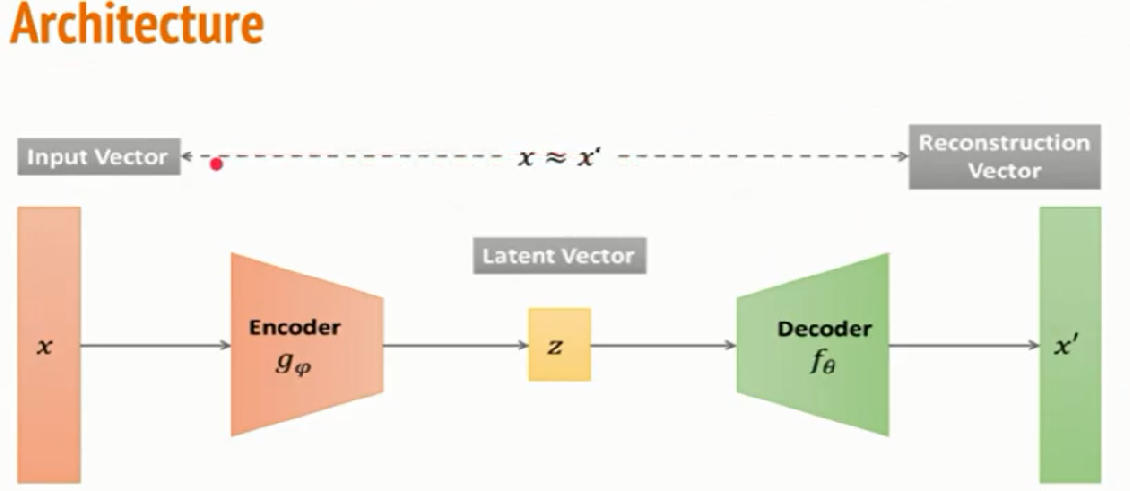

In [38]:
encoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=tf.expand_dims(X_train_big, -1).shape[1:]),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
    tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)
])

decoder = tf.keras.Sequential([
    tf.keras.layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
    tf.keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
    tf.keras.layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')
])
autoencoder = tf.keras.Sequential([encoder, decoder])

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

history = autoencoder.fit(
    tf.expand_dims(X_train_big, -1),tf.expand_dims(X_train_big, -1),
    epochs=10,
    batch_size=128,
    validation_split=0.1
)

Epoch 1/10
64/64 [==============================] - 1s 12ms/step - loss: -62805.5430 - val_loss: -545503.1875
Epoch 2/10
64/64 [==============================] - 1s 10ms/step - loss: -30864850.0000 - val_loss: -149615184.0000
Epoch 3/10
64/64 [==============================] - 1s 10ms/step - loss: -1012158144.0000 - val_loss: -2997286400.0000
Epoch 4/10
64/64 [==============================] - 1s 10ms/step - loss: -9441647616.0000 - val_loss: -21059530752.0000
Epoch 5/10
64/64 [==============================] - 1s 10ms/step - loss: -46650175488.0000 - val_loss: -86970679296.0000
Epoch 6/10
64/64 [==============================] - 1s 10ms/step - loss: -158264688640.0000 - val_loss: -262362759168.0000
Epoch 7/10
64/64 [==============================] - 1s 10ms/step - loss: -421339103232.0000 - val_loss: -643708157952.0000
Epoch 8/10
64/64 [==============================] - 1s 10ms/step - loss: -951170039808.0000 - val_loss: -1368532320256.0000
Epoch 9/10
64/64 [==========================

#### Creating the reconstruction error

In [22]:
reconstructed = autoencoder.predict(X_train_big)
reconstruction_error = np.mean(np.power( tf.expand_dims(X_train_big, -1) - reconstructed, 2), axis=(1,2,3))
reconstruction_error

283/283 [==============================] - 0s 1ms/step


array([14955.148, 26328.266, 13165.101, ..., 21640.93 , 14205.654,
       12532.289], dtype=float32)

#### Setting the threshold

In [23]:
threshold = np.quantile(reconstruction_error, 0.99)  
outliers = X_train_big[reconstruction_error > threshold]

#### Looking at the outlier

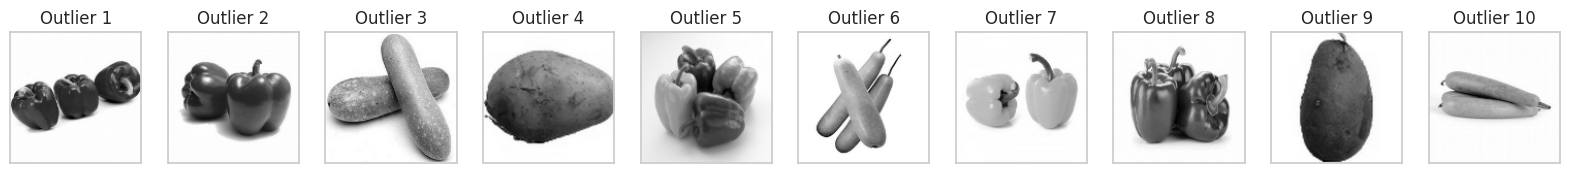

In [24]:
n = 10 
plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(outliers[i]) 
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(f'Outlier {i+1}')
plt.show()

#### Getting the labels

In [26]:
non_outliers_labels = y_train_big[reconstruction_error <= threshold]

#### Setting the cutmix

In [27]:
train_ds_one = tf.data.Dataset.from_tensor_slices((non_outliers, non_outliers_labels)).shuffle(2048).map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
train_ds_two = tf.data.Dataset.from_tensor_slices((non_outliers, non_outliers_labels)).shuffle(2048).map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)

val_ds_cutmix = tf.data.Dataset.from_tensor_slices((X_val_big, y_val_big))
val_ds_cutmix = val_ds_cutmix.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE).batch(128).prefetch(tf.data.AUTOTUNE)

train_ds_cutmix = tf.data.Dataset.zip((train_ds_one, train_ds_two))
train_ds_cutmix = (
    train_ds_cutmix.shuffle(1024)
    .map(cutmix, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(128)
    .prefetch(tf.data.AUTOTUNE)
)
train_ds_cutmix

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None))>

### Define the best model period

In [42]:
def CNN2():

    filters_list = [32, 64, 128, 128, 128, 128]

    model = Sequential()

    # Add initial convolutional layers
    model.add(Conv2D(filters=filters_list[0], kernel_size=(3, 3), padding='same', input_shape=(128, 128, 1)))
    model.add(BatchNormalization())
    model.add(ReLU())

    model.add(Conv2D(filters=filters_list[1], kernel_size=(3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())

    for filters in filters_list[2:]:
        model.add(Conv2D(filters=filters, kernel_size=(3, 3), padding='same'))
        model.add(BatchNormalization())
        model.add(ReLU())

    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(15, activation='softmax')) 

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model
cnn2_model = CNN2()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 128, 128, 32)      320       
                                                                 
 batch_normalization_4 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                                 
 re_lu_4 (ReLU)              (None, 128, 128, 32)      0         
                                                                 
 conv2d_8 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 batch_normalization_5 (Batc  (None, 128, 128, 64)     256       
 hNormalization)                                                 
                                                                 
 re_lu_5 (ReLU)              (None, 128, 128, 64)     

#### Running the model

In [43]:
cnn2_model.fit(train_ds_cutmix,validation_data = val_ds_cutmix, epochs=100, batch_size=64,  callbacks=[EarlyStopping(monitor='accuracy', patience=10, restore_best_weights=True), ReduceLROnPlateau(patience=5)])

Epoch 1/100
70/70 [==============================] - 18s 252ms/step - loss: 1.8270 - accuracy: 0.4479 - val_loss: 2.5557 - val_accuracy: 0.1390 - lr: 0.0010
Epoch 2/100
70/70 [==============================] - 18s 251ms/step - loss: 1.2621 - accuracy: 0.6323 - val_loss: 3.5946 - val_accuracy: 0.2403 - lr: 0.0010
Epoch 3/100
70/70 [==============================] - 18s 252ms/step - loss: 0.9538 - accuracy: 0.7414 - val_loss: 2.7227 - val_accuracy: 0.2867 - lr: 0.0010
Epoch 4/100
70/70 [==============================] - 18s 252ms/step - loss: 0.7399 - accuracy: 0.8121 - val_loss: 8.4992 - val_accuracy: 0.1467 - lr: 0.0010
Epoch 5/100
70/70 [==============================] - 18s 252ms/step - loss: 0.5996 - accuracy: 0.8580 - val_loss: 2.8083 - val_accuracy: 0.3207 - lr: 0.0010
Epoch 6/100
70/70 [==============================] - 18s 252ms/step - loss: 0.5287 - accuracy: 0.8858 - val_loss: 5.8651 - val_accuracy: 0.1933 - lr: 0.0010
Epoch 7/100
70/70 [==============================] - 18s 2